In [12]:
import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import pickle
import seaborn as sns
import sys
import numpy as np
import scipy.optimize as op
from scipy.optimize import curve_fit

sns.set_palette("coolwarm",15)
sns.set_style("whitegrid")

import emcee

In [3]:
file=open( '../../../data/raw_data/20160428_1313_W1204_ref.pkl' , 'rb')
d=pickle.load(file)
file.close()

i = 8
Nsize = 2**i
dt=(1/(d['sample freq'])) #period
T1=dt*(Nsize) #full period
v=(d['speed'])
X = v*T1 #full distance
dx = dt*v #smallest amount of distance travelled
total_t = (d['scan time']) #how long it ran
    
total_s = (d['samples requested']) #number of samples 
startpt = ((total_s - Nsize)/2) #starting point


endpt = startpt + Nsize #ending point


df = 1/T1
f = df*np.arange(Nsize/2)+df/2.0
fFull = df*np.arange((Nsize/2) + 1)+df/2.0


y = (d['sig0F']) 
D = y[startpt:endpt]
D = np.flipud(D)

a = d['delay0F']/v
t = a[startpt:endpt]

For the last few days we have been working on finding the proper time constant for deconvolution. We did so previously through corner plots and matrices as well as plot fitting with the Data and a Model.

From the data from the chopper, we got the value tau = .049, and tau2 = .559. 

The equation of the model is the same, however we are now using the Markov Chain Monte Carlo to generate the optimal values. 
The first attempt using MCMC is recorded here. 

Mira

In [4]:
#model function convoluted with RC circuit and AC coupling function
def psi1(znot,q,p,T):
    Ns = 256
    z = t
    dz = z[2]-z[1]
    f = np.linspace(0,0.5/dz, np.floor(Ns/2))
    f_full = np.linspace(0,0.5/dz, np.floor(Ns/2) +1)
    #original function
    y0=-np.cos(2*np.pi*q*(z-znot))*(np.exp(-((z-znot)**2)/(2*p**2)))/(np.sqrt(2*np.pi)*p)
    yf0=np.fft.rfft(y0)
    K_det =(1/(1+(1j*2*np.pi*f_full*T))) #kernel from detector
    K_cc =(2*np.pi*f_full*.559)/(1 + (1j*2*np.pi*.559)) #kernel from AC coupling
    K_f = np.multiply(K_det,K_cc)
    y1=np.fft.irfft(yf0*K_f*2*np.pi)
    return t,y1
#znot = 0.012, q = 8.57718120805, p = .04

The likelihood function is defined as:

ln(likelihood function) = (-.5*(D-Modelf*a)^2)/(Sigma)-log(1/Sig)

In [7]:
#likelihood function
#why is it ln?
def lnlike(params, t, D):
    znot, q, p, T, a = params 
    t,Modelf = psi1(znot,q,p, T)
    Dev = -.5*(np.dot((D-Modelf*a),D-Modelf*a))
    Sig=0.0005
    return (Dev/Sig)-np.log(1/Sig) #sigma? if sigma is large it becomes shallower

The range of sigma is determined by plotting the difference between an estimated Model and Data. the two plots, the difference between the two plots, and the histogram of the differences are shown below.

<function matplotlib.pyplot.legend>

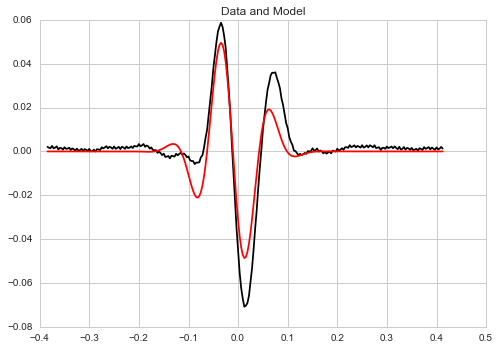

In [17]:
pl.plot(t,D, color = 'black', label = 'Data')
pl.plot(x,Model*.0002, color = 'red', label = 'Model')
pl.title('Data and Model')
pl.legend

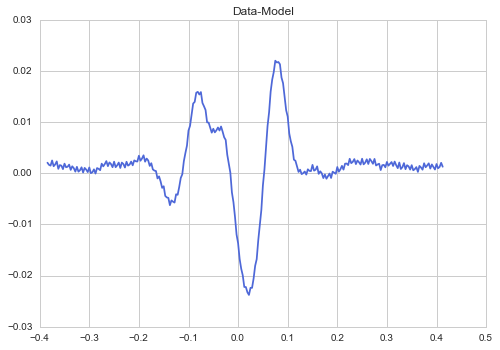

In [16]:
x,Model = psi1(-.02,9,.05,.02)
y = D-Model*.0002
pl.plot(x,y)
pl.title('Data-Model')

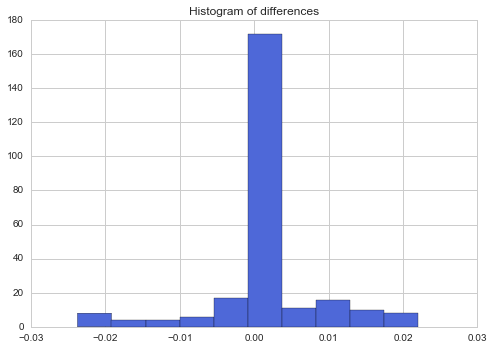

In [18]:
pl.hist(y)
pl.title('Histogram of differences')

The range of this histogram is essentially the range of Sigma. It should be no greater than .02.
In fact, the average perfect sigma should be equal to the standard deviation of the difference, D-Model.
This is shown to be 0.00729, while the standard deviation of the Data is the minimum sigma,0.0005305.

In [19]:
nll = lambda *args: -lnlike(*args) 
result = op.minimize(nll, [-.02, 8.57, .05, .02, .0002], args=(t,D))
znot1,q1,p1,T1,a1 = result["x"]
#print result ["x"]

The prior function is defined as:
ln(prior function) = 0.0 if within the limitations of the parameters, negative infinity if beyond the limiations of the parameters.

the limits of the parameters are
-.08 < znot < .08 and 1.0 < q < 15.0 and .01 < p < .1 and 0.0 < T < .06 and 0.0 < a < .0005:


In [9]:
def lnprior(params):
    znot, q, p, T, a = params 
    if -.08 < znot < .08 and 1.0 < q < 15.0 and .01 < p < .1 and 0.0 < T < .06 and 0.0 < a < .0005:
        return 0.0
    return -np.inf 

The probability function is defined as: 
lnprior + lnlike unless lnprior is negative infinity

In [10]:
#log probability function
def lnprob (params, t, D):
    lp = lnprior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(params, t, D)

there are five free parameters and so five dimension. 
We chose 260 walkers somewhat arbitrarily.

In [11]:
ndim, nwalkers = 5,260
pos = [result["x"] + 10**(-4)*np.random.randn(ndim) for i in range(nwalkers)]

In [13]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob, args=(t,D))

We also chose 5000 steps after finding the correct sigma and attempting to get the walkers to settle.

In [33]:
sampler.run_mcmc(pos, 5000); #number of steps

The plots below show the progress of one of the arbitrarily chosen walkers for each parameter. From these it can be decided where/when the walkers settle into their final locations.

(260, 5000, 5)


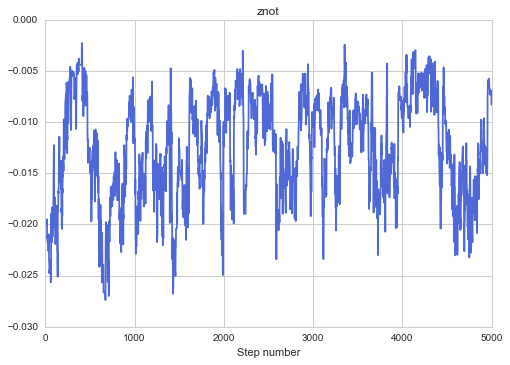

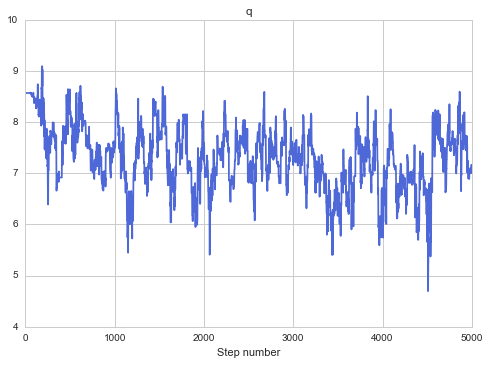

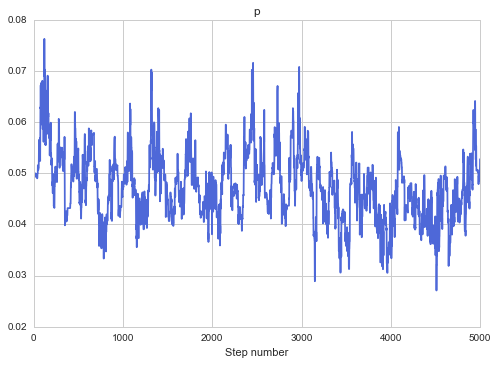

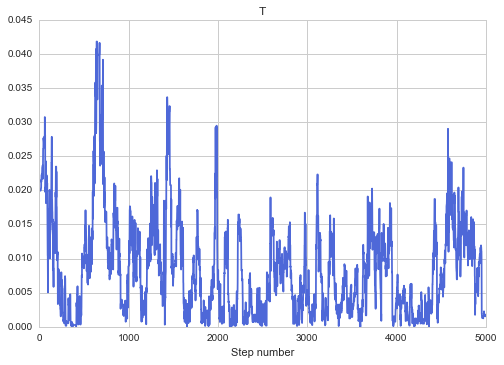

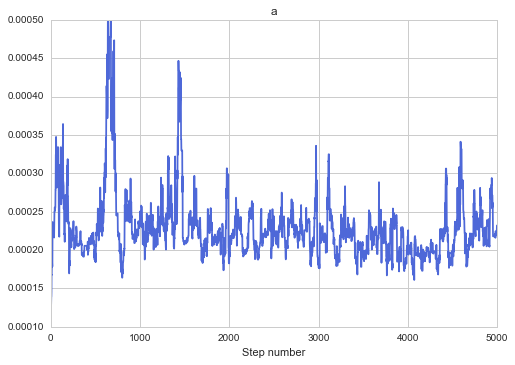

In [29]:
walks=(sampler.chain)
print(np.shape(walks))

for nn in range(0,ndim):
    pl.plot(walks[1,:,nn])
    titles=['znot','q','p','T','a']
    pl.xlabel('Step number')
    pl.title(str(titles[nn]))
    pl.show() #sigma = .001

In [31]:
samples = sampler.chain[:,2000:,:].reshape([-1, ndim])
#print(np.shape(samples))

Using this information, corner plots and histograms are made representing the original guessed values, the plots, and the probabilities. 

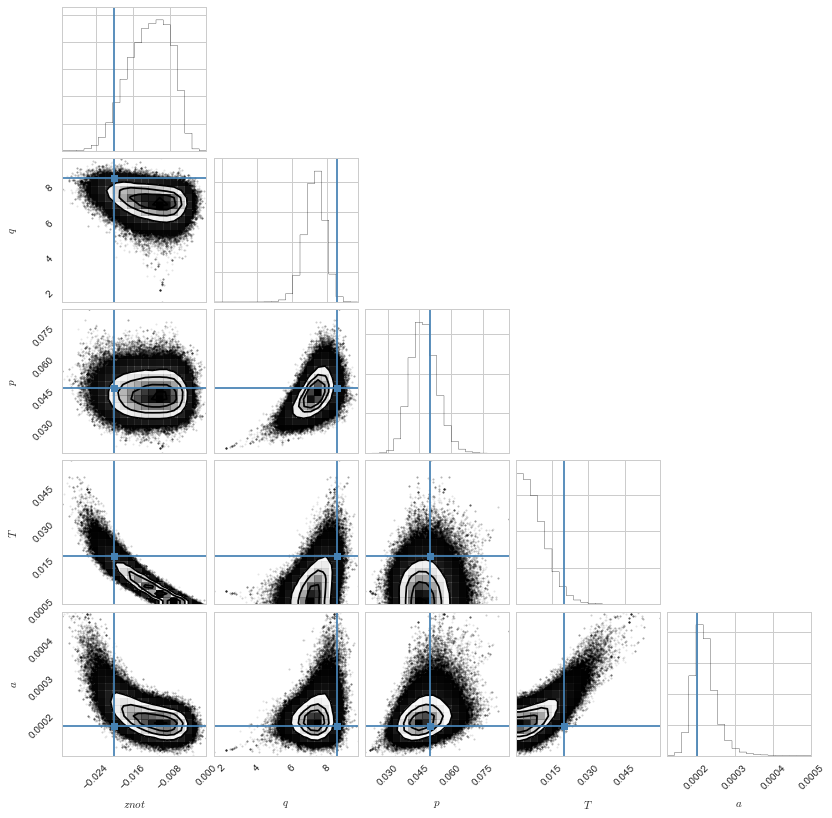

In [32]:
import corner
fig = corner.corner(samples, labels=["$znot$", "$q$", "$p$", "$T$", "$a$"], 
                    truths=[-.02, 8.57, .05, .02, .0002])
fig.savefig("MCMCattempt1.png")

It is clear that there is some tailoring needed to be done. 